In [ ]:
%pip install gymnasium gym matplotlib numpy pandas 

In [2]:
# imports
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

In [3]:
# import the blackjack environment
name = 'Blackjack-v1'
env = gym.make(name) # warning: setting slippery=True results in very complex environment dynamics where the optimal solution does not make sense to humans!

## Implementacion de una politica

In [4]:
def politica_aleatoria(estado):
    # Acción aleatoria: 0 = Stick, 1 = Hit
    return random.choice([0, 1])

## Simular un episodio

In [5]:

def simular_episodio(env, politica=None, render=False):
    estados = []
    acciones = []
    recompensas = []
    estado, _ = env.reset()
    terminado = False

    while not terminado:
        if render:
            env.render()
        if politica is not None:
            accion = politica(estado)
        else:
            accion = env.action_space.sample()
        nuevo_estado, recompensa, terminado, _, _ = env.step(accion)
        estados.append(estado)
        acciones.append(accion)
        recompensas.append(recompensa)
        estado = nuevo_estado

    return estados, acciones, recompensas

## Estimar el valor de Q(s, a) y seleccionar la politica basado en epsilon-greedy

In [38]:
# Política epsilon-greedy basada en Q y MC Control on-policy (primera visita)

def politica_epsilon_greedy(Q, nA, epsilon: float = 0.1):
    def policy_fn(estado):
        # Explorar con prob epsilon o si el estado aún no tiene buen estimado
        if np.random.rand() < epsilon or estado not in Q:
            return random.randrange(nA)
        return int(np.argmax(Q[estado]))
    return policy_fn


def estimar_Q_epsilon_greedy(env, num_episodios: int = 500000, epsilon: float = 0.1, gamma: float = 1.0):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA, dtype=float))
    # Conteos para promedio incremental por (s,a)
    N = defaultdict(lambda: np.zeros(nA, dtype=int))

    for _ in range(num_episodios):
        politica = politica_epsilon_greedy(Q, nA, epsilon)
        estados, acciones, recompensas = simular_episodio(env, politica)
        # Retorno de primera visita hacia atrás
        G = 0.0
        visitados = set()
        for t in reversed(range(len(estados))):
            s, a, r = estados[t], acciones[t], recompensas[t]
            G = gamma * G + r
            if (s, a) in visitados:
                continue
            visitados.add((s, a))
            N[s][a] += 1
            alpha = 1.0 / N[s][a]
            Q[s][a] += alpha * (G - Q[s][a])
    return Q

In [53]:
# Entrenamiento con snapshots y visualización de la evolución de la política

def _snapshot_Q(Q):
    # Copia simple: dict estado -> vector Q(s, :)
    return {s: v.copy() for s, v in Q.items()}


def estimar_Q_epsilon_greedy_con_snapshots(env, num_episodios=500000, epsilon=0.1, gamma=1.0, max_snapshots=5):
    """MC on-policy epsilon-greedy (primera visita) registrando hasta max_snapshots Q intermedios.
    Devuelve: Q_final, snapshots (lista de (episodio, Q_snapshot))."""
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA, dtype=float))
    N = defaultdict(lambda: np.zeros(nA, dtype=int))

    # Episodios donde tomar snapshot, espaciados uniformemente e incluyendo el final
    snaps = np.unique(np.linspace(1, num_episodios, num=min(max_snapshots, num_episodios), dtype=int)).tolist()
    snapshots = []

    for ep in range(1, num_episodios + 1):
        politica = politica_epsilon_greedy(Q, nA, epsilon)
        estados, acciones, recompensas = simular_episodio(env, politica)

        G = 0.0
        visitados = set()
        for t in reversed(range(len(estados))):
            s, a, r = estados[t], acciones[t], recompensas[t]
            G = gamma * G + r
            if (s, a) in visitados:
                continue
            visitados.add((s, a))
            N[s][a] += 1
            alpha = 1.0 / N[s][a]
            Q[s][a] += alpha * (G - Q[s][a])

        if ep in snaps:
            snapshots.append((ep, _snapshot_Q(Q)))

    return Q, snapshots


def plot_policy_snapshot(Q, titulo):
    """Dibuja la política greedy derivada de Q para 'Sin As usable' y 'As usable' (en ese orden), con Y descendente y colores de evolucion_por_estado."""
    player_sums = np.arange(12, 22)
    dealer_cards = np.arange(1, 11)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    last_im = None
    for idx, usable_ace in enumerate([False, True]):  # 'Sin As usable' primero
        grid = np.zeros((len(player_sums), len(dealer_cards)))
        for i, ps in enumerate(player_sums):
            for j, dc in enumerate(dealer_cards):
                s = (ps, dc, usable_ace)
                grid[i, j] = np.argmax(Q[s]) if s in Q else np.nan
        grid_disp = np.flipud(grid)
        ax = axes[idx]
        # Usar mismo esquema de color y escala que evolucion_por_estado
        last_im = ax.imshow(grid_disp, cmap=plt.cm.coolwarm, vmin=0, vmax=1)
        ax.set_title('Sin As usable' if not usable_ace else 'As usable')
        ax.set_xlabel('Dealer mostrando')
        ax.set_xticks(np.arange(len(dealer_cards)))
        ax.set_xticklabels(["A" if d == 1 else str(d) for d in dealer_cards])
        if idx == 0:
            ax.set_ylabel('Suma del jugador')
            ax.set_yticks(np.arange(len(player_sums)))
            ax.set_yticklabels(player_sums[::-1])
    # Colorbar compartida con mismo label que evolucion_por_estado
    plt.suptitle(titulo)
    plt.tight_layout()
    plt.show()


def graficar_evolucion_politica(snapshots, total_episodios):
    for ep, Qsnap in snapshots:
        plot_policy_snapshot(Qsnap, f"Evolución de la política — episodio {ep} / {total_episodios}")

## Evaluar la politica

In [8]:
def evaluar_politica(env, politica, num_episodios=10000):
    ganancias = []
    for _ in range(num_episodios):
        _, _, recompensas = simular_episodio(env, politica)
        ganancias.append(sum(recompensas))
    return np.mean(ganancias)


## Graficas

In [27]:
def imprimir_politica(policy_actions, iteration=0):
    print(f"Iteración: {iteration}\n"+ "\n  ".join([f"Estado: {estado}, Acción: {accion}" for estado, accion in policy_actions.items()]))
    
def evolucion_por_estado(Q, evaluacion_cada=5000):
    player_sums = np.arange(12, 22)
    dealer_cards = np.arange(1, 11)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    for idx, usable_ace in enumerate([False, True]):
        policy = np.zeros((len(player_sums), len(dealer_cards)))
        for i, player in enumerate(player_sums):
            for j, dealer in enumerate(dealer_cards):
                state = (player, dealer, usable_ace)
                if state in Q:
                    policy[i, j] = np.argmax(Q[state])
                else:
                    policy[i, j] = np.nan  # Estado no visitado
        # Mostrar la Y de forma descendente (21 arriba -> 12 abajo)
        policy_disp = np.flipud(policy)
        ax = axes[idx]
        cax = ax.matshow(policy_disp, cmap=plt.cm.coolwarm, vmin=0, vmax=1)
        ax.set_title(f"As usable: {usable_ace}")
        ax.set_xlabel("Carta del dealer")
        ax.set_ylabel("Suma del jugador")
        ax.set_xticks(np.arange(len(dealer_cards)))
        ax.set_yticks(np.arange(len(player_sums)))
        ax.set_xticklabels(dealer_cards)
        # Etiquetas descendentes para que coincidan con el flip vertical
        ax.set_yticklabels(player_sums[::-1])
    fig.colorbar(cax, ax=axes, orientation='vertical', label='Acción óptima (0=Stick, 1=Hit)')
    plt.suptitle("Política óptima aprendida por estado")
    plt.show()
    

def plot_blackjack_policy_surface(Q, usable_ace=True):
    player_sums = np.arange(12, 22)
    dealer_cards = np.arange(1, 11)
    # Queremos X = carta del dealer, Y = suma del jugador
    X, Y = np.meshgrid(dealer_cards, player_sums)
    Z = np.zeros_like(X, dtype=float)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # state = (suma_jugador, carta_dealer, as_usable)
            state = (Y[i, j], X[i, j], usable_ace)
            if state in Q:
                # Valor esperado máximo sobre acciones: V*(s) = max_a Q(s,a)
                Z[i, j] = np.max(Q[state])
            else:
                Z[i, j] = np.nan

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='green')
    ax.set_xlabel('Carta del dealer')
    ax.set_ylabel('Suma del jugador')
    ax.set_zlabel('Valor esperado (ganancia)')
    ax.set_title(f'Valor esperado V* (As usable: {usable_ace})')
    plt.show()

## Prueba

In [41]:
# Entrenar usando MC on-policy con epsilon-greedy
Q = estimar_Q_epsilon_greedy(env, num_episodios=1000000, epsilon=0.1, gamma=1.0)

# Política epsilon-greedy para actuar
politica_eps = politica_epsilon_greedy(Q, env.action_space.n, epsilon=0.05)
politica_optima = politica_greedy(Q)

# Evaluar política greedy derivada de Q (determinista)
rendimiento = evaluar_politica(env, politica_optima)
print(f"Rendimiento promedio de la política greedy derivada de Q: {rendimiento:.4f}")

Rendimiento promedio de la política greedy derivada de Q: -0.0441


### Visualización de la evolución de la política a lo largo de los episodios

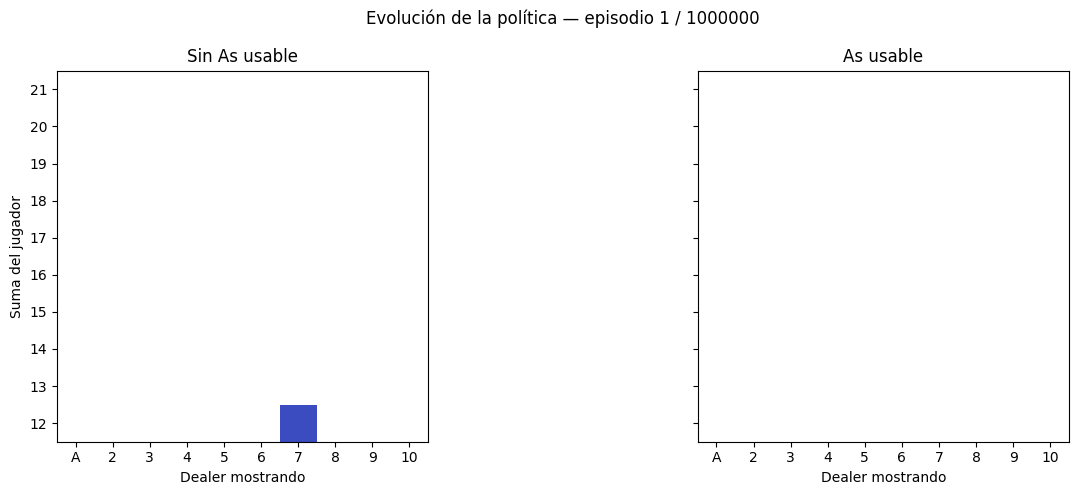

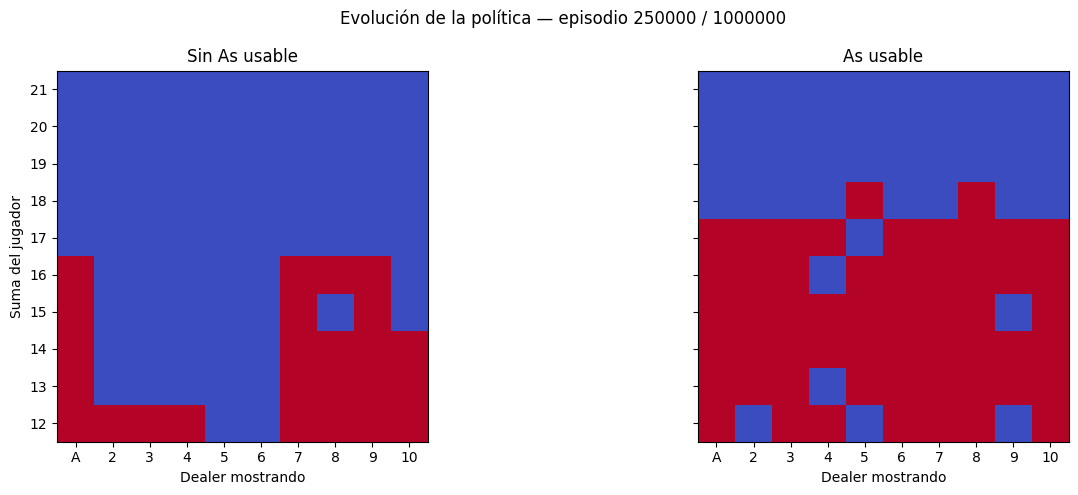

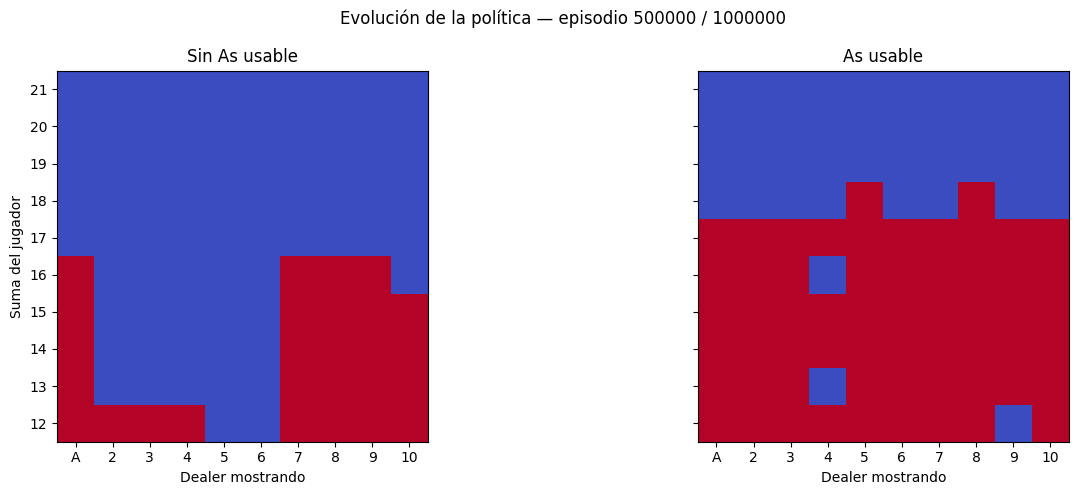

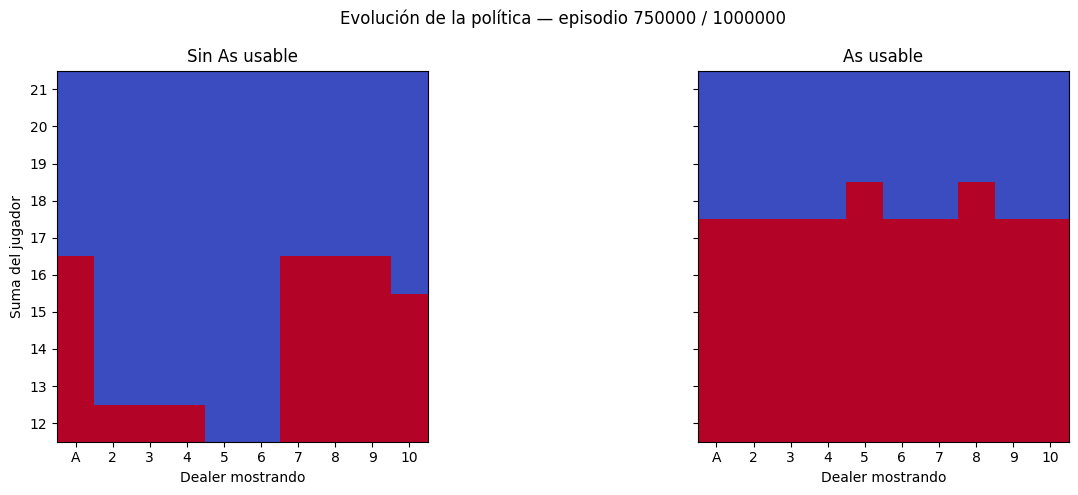

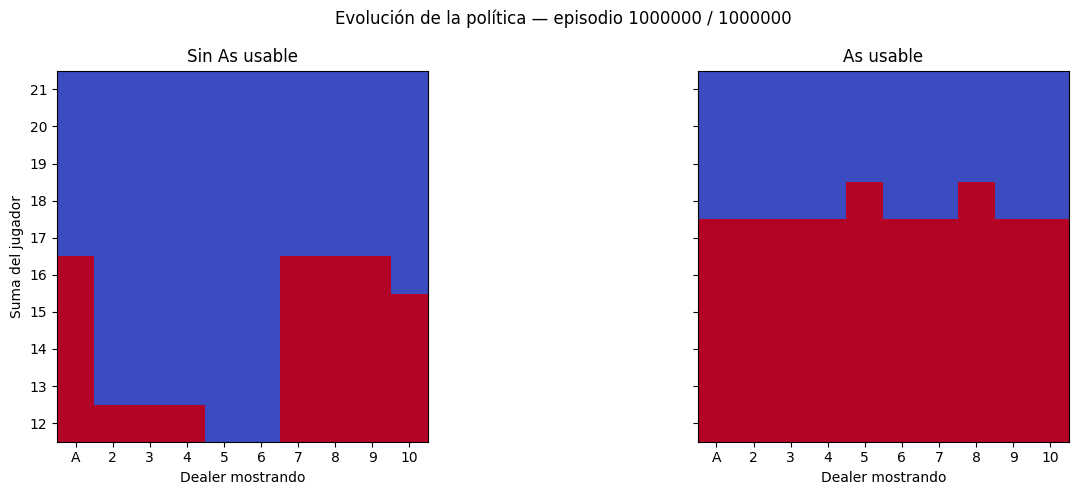

Rendimiento (greedy) tras 1000000 episodios: -0.0482


In [56]:
# Visualizar evolución de la política (máximo 5 snapshots)
N = 1000000
Q_snap, snapshots = estimar_Q_epsilon_greedy_con_snapshots(env, num_episodios=N, epsilon=0.1, gamma=1.0, max_snapshots=5)
graficar_evolucion_politica(snapshots, total_episodios=N)

# Mantener Q final entrenado
Q = Q_snap
politica_optima = politica_greedy(Q)
rendimiento = evaluar_politica(env, politica_optima)
print(f"Rendimiento (greedy) tras {N} episodios: {rendimiento:.4f}")

### Resultado final

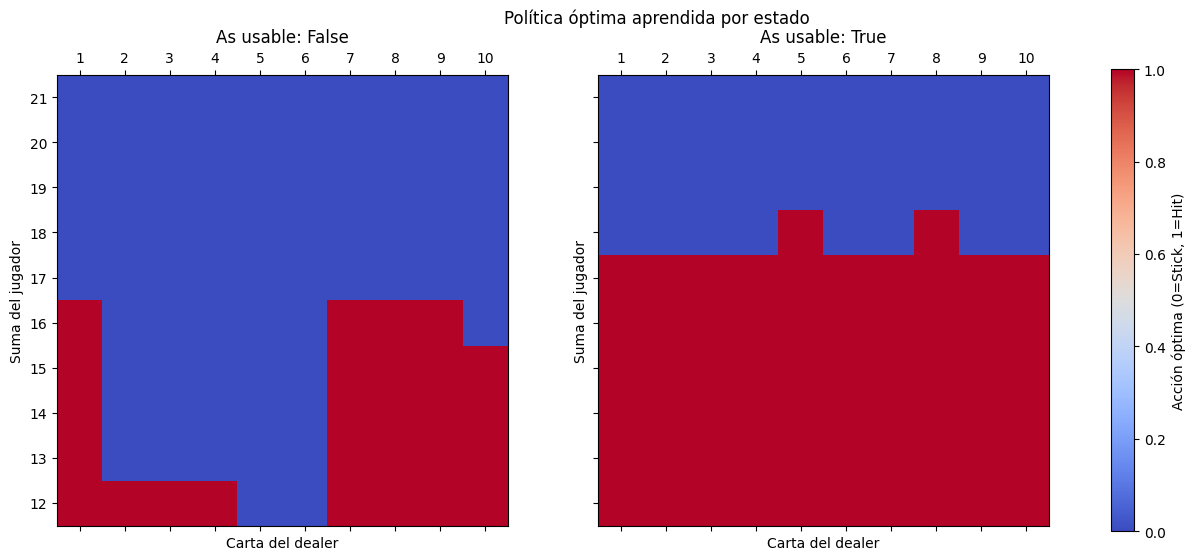

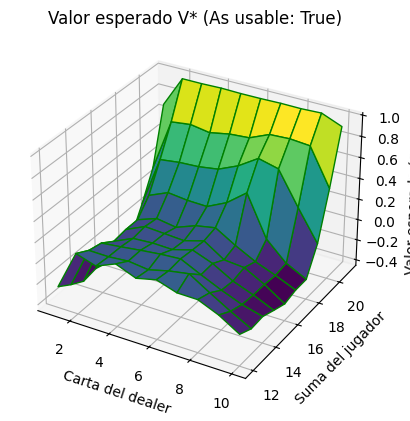

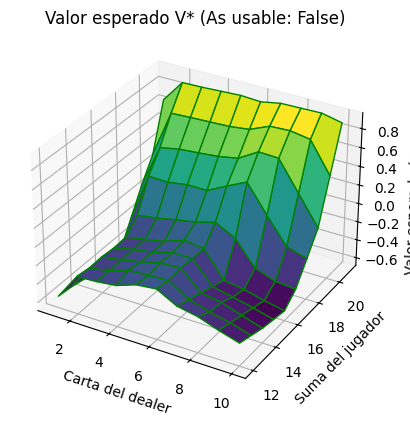

In [57]:
evolucion_por_estado(Q)
plot_blackjack_policy_surface(Q, usable_ace=True)
plot_blackjack_policy_surface(Q, usable_ace=False)
